class email:
    def __init__(self, id, message_id, data, subject, sender, receiver, day_week, time, time_zone, date, beginning, farewell, answer, length, SA, relative_path):
    
        self._id = id
        self._message_id = message_id
        self._data = data
        
        # Verificar si 'subject' es una lista y convertirlo a cadena si es necesario
        if isinstance(subject, list):
            subject = " ".join(subject)
        
        self._subject = subject
        self._sender = sender
        self._receiver = receiver
        self._number_of_receivers = len(receiver)
        self._day_week = day_week
        self._time = time
        self._time_zone = time_zone
        self._date = date
        self._responded = False
        self._responses = set()
        self._beginning = beginning
        self._farewell = farewell
        self._answer = answer
        self._length = length
        self._SentA = SA

        # Determinar si el correo es una respuesta y almacenar el resultado
        self._is_reply = self._subject.startswith("Re: ")
        
        self._relative_path = relative_path


### VARIABLES IMPORTANTES

- answer (categorica)

- Subject (string)
- number_of_receivers (int)
- day_week (categórical)
- time (date)
- body (string)
- length (int)


In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
df = pd.read_json('emails.json', lines= True)
df.fillna(' ', inplace=True)


# Seleccionar columnas para características y variable objetivo
X_cols = ['subject', 'day_week', 'length', 'body', 'adjusted_time','number_of_receivers'] 
X = df[X_cols]
y = df['answer']

In [3]:
model_df = df[['subject', 'day_week', 'body','adjusted_time', 'length','number_of_receivers','answer',]]
model_df['adjusted_time'] = model_df['adjusted_time'].dt.time
model_df

C:\Users\hugol\AppData\Local\Temp\ipykernel_14664\1215153414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['adjusted_time'] = model_df['adjusted_time'].dt.time


,subject,day_week,body,adjusted_time,length,number_of_receivers,answer
0,"December 14, 2000 - Bear Stearns' predictions ...",Wed,\nIn today's Daily Update you'll find free rep...,18:41:00,short,1,0
1,Bloomberg Power Lines Report,Wed,\nHere is today's copy of Bloomberg Power Line...,08:35:00,short,1,0
2,Consolidated positions: Issues & To Do list Co...,Mon,\n---------------------- Forwarded by Phillip ...,06:16:00,short,1,0
3,Consolidated positions: Issues & To Do list Co...,Mon,\n---------------------- Forwarded by Phillip ...,06:00:00,short,1,0
4,,Thu,"\nDave, \n\n Here are the names of the west de...",05:26:00,short,1,0
...,...,...,...,...,...,...,...
20519,RE: Transmission Service Agreements,Tue,\n\n\n -----Original Message-----\nFrom: \tRob...,08:58:13,short,1,1
20520,Transmission Service Agreements,Mon,\nI've incorporated Don Baughman's info into t...,16:03:39,short,1,0
20521,FW: transmission agreements,Mon,\nDo you already have this list. Please send...,10:41:28,short,1,1
20522,NETCO Implemention Template,Wed,\nFrom Kevin Presto:\n\nAttached is the spread...,14:59:01,short,1,0


### MODELO

In [4]:
def extract_hour(X):
    # Verifica si X es un DataFrame y selecciona la columna adecuada, de lo contrario, asume que es un ndarray
    if isinstance(X, pd.DataFrame):
        times = pd.to_datetime(X.iloc[:, 0], format='%H:%M:%S', errors='coerce')
    else:
        times = pd.to_datetime(X[:, 0], format='%H:%M:%S', errors='coerce')

    # Extraer solo la hora
    hours = times.dt.hour
    return hours.values.reshape(-1, 1)



# Transformador para extraer la hora
extract_hour_transformer = FunctionTransformer(extract_hour, validate=False)



from sklearn.preprocessing import FunctionTransformer

# Usa validate=False si estás seguro de que tus datos de entrada son adecuados y no necesitas validación de datos de entrada.
#time_cos_transformer = FunctionTransformer(extract_cos_time, validate=False)
#time_sin_transformer = FunctionTransformer(extract_sin_time, validate=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('subject_vect', TfidfVectorizer(), 'subject'),
        ('body_vect', TfidfVectorizer(), 'body'),
        ('day_week_enc', OneHotEncoder(), ['day_week']),
        ('time_hour_enc', Pipeline([
            ('extract_hour', extract_hour_transformer),
            ('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))
        ]), ['adjusted_time']),
        #('num_recievers', StandardScaler(), ['_number_of_receivers']),
        ('length', OneHotEncoder(), ['length'])
    ],
    remainder='passthrough'
)


model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs',penalty='l2',  C=1.0, class_weight='balanced', max_iter=10000, random_state=42))
])

# Suponiendo que 'X' y 'y' están definidos y apropiadamente preparados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]  # Probabilidades para la clase 1

accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUC Score: {auc_score:.2f}")

Accuracy: 0.98
AUC Score: 0.99


##### CROSS-VALIDATION F1-score

In [5]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Definir el esquema de validación cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Preparar el scorer para F1-score
f1_scorer = make_scorer(f1_score)

# Calcular el F1-score para cada partición de la validación cruzada
f1_scores = cross_val_score(model_pipeline, X, y, cv=kfold, scoring=f1_scorer)

# Imprimir los resultados
print(f"Cross-Validated F1 Scores: {f1_scores}")
print(f"Mean F1-Score: {f1_scores.mean():.2f} +/- {f1_scores.std():.2f}")



Cross-Validated F1 Scores: [0.97204446 0.97142857 0.97194998 0.9704584  0.97312011]
Mean F1-Score: 0.97 +/- 0.00


### Contribución de características para recibir respuesta 

In [6]:
def get_feature_names(column_transformer):
    """Genera nombres de características para todos los transformadores en ColumnTransformer."""
    feature_names = []
    
    # Loop a través de todos los transformadores en el ColumnTransformer
    for transformer_name, transformer, columns in column_transformer.transformers_:
        # Ignorar transformadores que simplemente eliminan columnas
        if transformer == 'drop' or transformer is None:
            continue
        
        # Extraer el último paso si el transformador es un Pipeline
        if isinstance(transformer, Pipeline):
            # Puede ser necesario adaptar esto si se requiere el nombre de una etapa anterior del pipeline
            transformer = transformer.steps[-1][1]

        # Recoger los nombres de las características de los transformadores individuales
        if hasattr(transformer, 'get_feature_names_out'):
            # Si el transformador tiene el método 'get_feature_names_out' (introducido en versiones recientes de Scikit-Learn)
            try:
                if isinstance(columns, list) or isinstance(columns, tuple):
                    # Si el transformador actúa sobre múltiples columnas
                    feature_names.extend([f"{transformer_name}_{name}" for name in transformer.get_feature_names_out()])
                else:
                    # Si el transformador actúa sobre una única columna
                    feature_names.extend([f"{transformer_name}_{name}" for name in transformer.get_feature_names_out()])
            except TypeError:
                # Manejar cualquier error de tipo que pueda surgir
                feature_names.extend([f"{transformer_name}_{i}" for i in range(transformer.n_output_features_)])
        else:
            # Para transformadores sin un método para obtener nombres de características (como algunas versiones antiguas de transformadores)
            if columns is not None:
                if isinstance(columns, list) or isinstance(columns, tuple):
                    # Asignar un nombre genérico basado en el nombre del transformador y la columna original
                    feature_names.extend([f"{transformer_name}_{col}" for col in columns])
                else:
                    # Caso en el que la columna no es una lista (es decir, probablemente una cadena)
                    feature_names.append(f"{transformer_name}_{columns}")
            else:
                # Caso raro en el que no hay columnas especificadas (poco común en práctica)
                feature_names.append(f"{transformer_name}_feature")

    return feature_names


In [7]:
# Asegúrate de que get_feature_names ya está definido como se mostró en mensajes anteriores

# Obtener nombres de características y coeficientes
feature_names = get_feature_names(model_pipeline.named_steps['preprocessor'])
coefficients = model_pipeline.named_steps['classifier'].coef_[0]

# Crear DataFrame para visualizar la importancia de cada característica
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
feature_importances['Absolute_Coefficient'] = feature_importances['Coefficient'].abs()
sorted_features = feature_importances.sort_values(by='Coefficient', ascending=False)

print(sorted_features)





                     Feature  Coefficient  Absolute_Coefficient
4018         subject_vect_re    21.406593             21.406593
78665      body_vect_subject     8.105226              8.105226
2166         subject_vect_fw     7.138465              7.138465
63653     body_vect_original     6.546208              6.546208
27468           body_vect_cc     6.207246              6.207246
...                      ...          ...                   ...
4599    subject_vect_spreads    -2.026283              2.026283
2639   subject_vect_inverses    -2.535769              2.535769
63156           body_vect_on    -2.551456              2.551456
26350           body_vect_by    -4.505911              4.505911
41513    body_vect_forwarded    -6.548985              6.548985

[90060 rows x 3 columns]


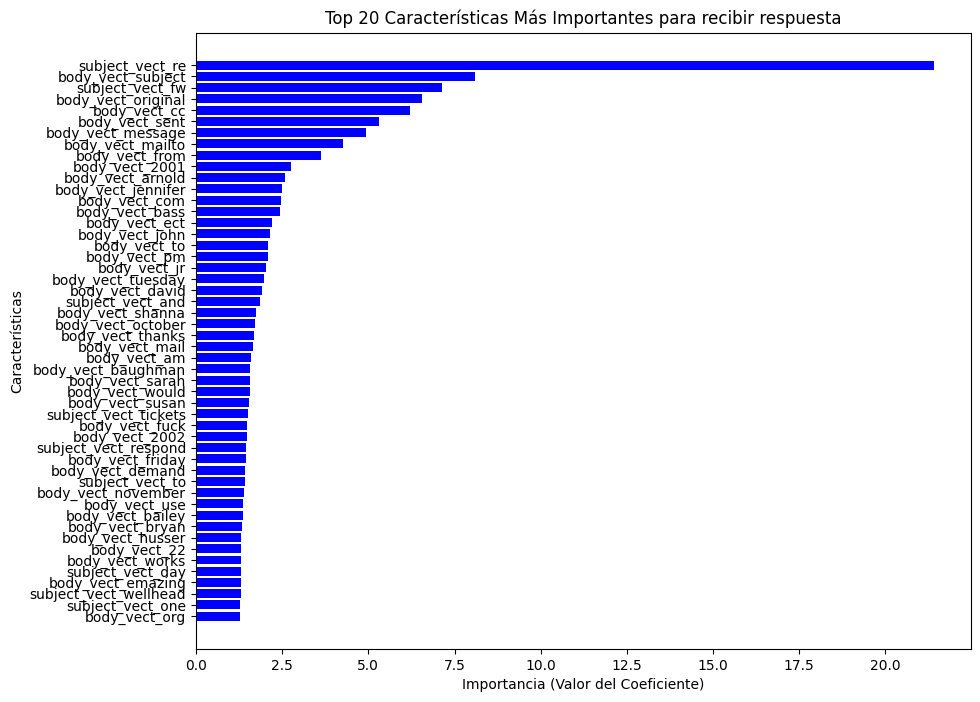

In [11]:
import matplotlib.pyplot as plt



# Seleccionar las top 20 características por coeficiente absoluto
top_features = sorted_features.head(50)

# Crear un gráfico de barras
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Absolute_Coefficient'], color='blue')
plt.xlabel('Importancia (Valor del Coeficiente)')
plt.ylabel('Características')
plt.title('Top 20 Características Más Importantes para recibir respuesta')
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
plt.show()


Por este lado concluimos que aquello que mejor ayuda a predecir si una correo recibirá respuesta es si contiene 'RE' en el asunto ocuerpo. Es decir si mi correo es un correo respondiendo a otro este tendrá más posibilidades de ser respondido.

**¿Qué día de la semana es mejor para mandar un correo?**

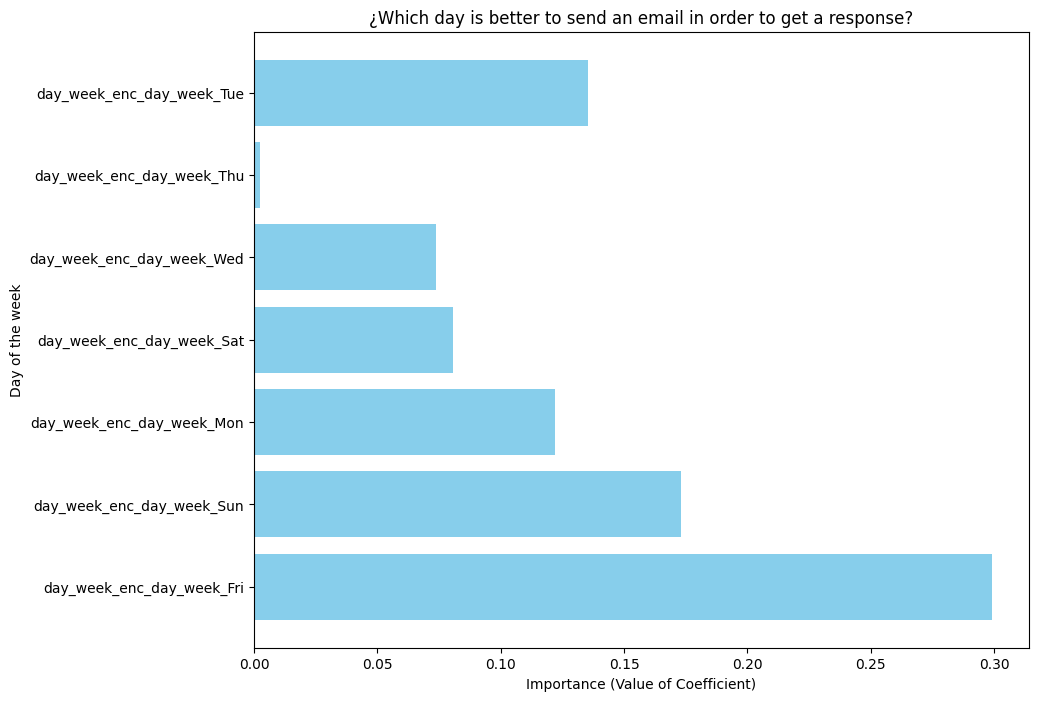

In [17]:
import matplotlib.pyplot as plt

# Asumiendo que sorted_features es tu DataFrame original
mask = ~sorted_features['Feature'].str.startswith('subject_') & ~sorted_features['Feature'].str.startswith('body_')& ~sorted_features['Feature'].str.startswith('num_')& ~sorted_features['Feature'].str.startswith('time')& ~sorted_features['Feature'].str.startswith('remainder')& ~sorted_features['Feature'].str.startswith('length')

# Aplicar la máscara para filtrar el DataFrame
filtered_features = sorted_features[mask]

# Seleccionar las top 20 características por coeficiente absoluto
top_features = filtered_features.head(50)

# Crear un gráfico de barras
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Absolute_Coefficient'], color='skyblue')
plt.xlabel('Importance (Value of Coefficient)')
plt.ylabel('Day of the week')
plt.title('¿Which day is better to send an email in order to get a response?')
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
plt.show()


**¿Qué hora es mejor para mandar un correo?**

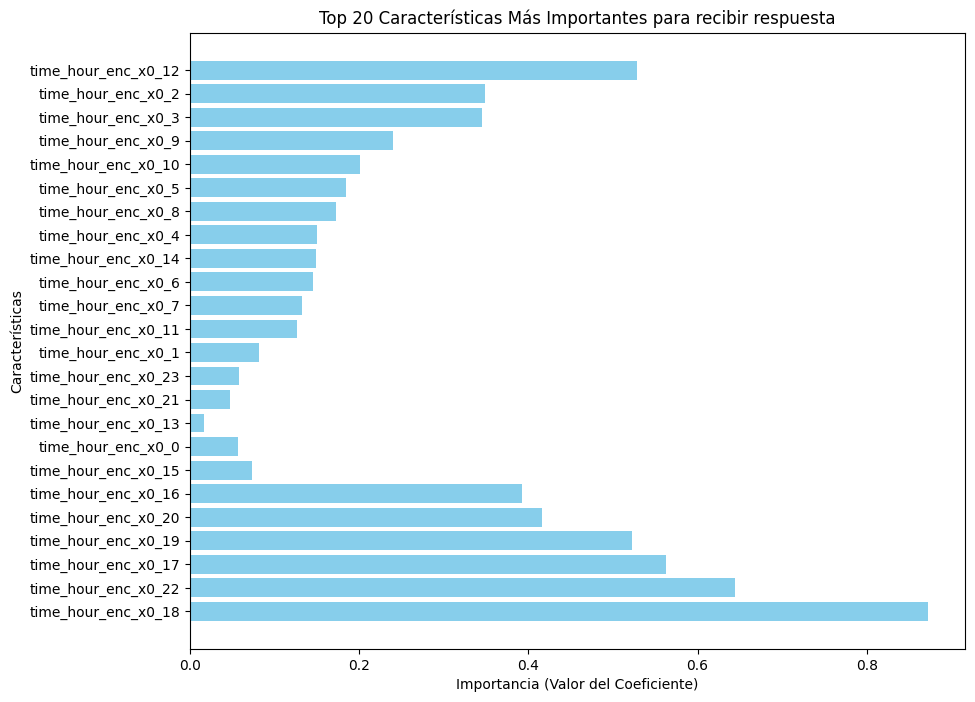

In [13]:
import matplotlib.pyplot as plt

# Asumiendo que sorted_features es tu DataFrame original
mask = ~sorted_features['Feature'].str.startswith('subject_') & ~sorted_features['Feature'].str.startswith('body_')& ~sorted_features['Feature'].str.startswith('num_')& ~sorted_features['Feature'].str.startswith('day_')& ~sorted_features['Feature'].str.startswith('remainder')& ~sorted_features['Feature'].str.startswith('length')

# Aplicar la máscara para filtrar el DataFrame
filtered_features = sorted_features[mask]

# Seleccionar las top 20 características por coeficiente absoluto
top_features = filtered_features.head(50)

# Crear un gráfico de barras
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Absolute_Coefficient'], color='skyblue')
plt.xlabel('Importancia (Valor del Coeficiente)')
plt.ylabel('Características')
plt.title('Top 20 Características Más Importantes para recibir respuesta')
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
plt.show()

**¿Qué longitud de correo es mejor?**

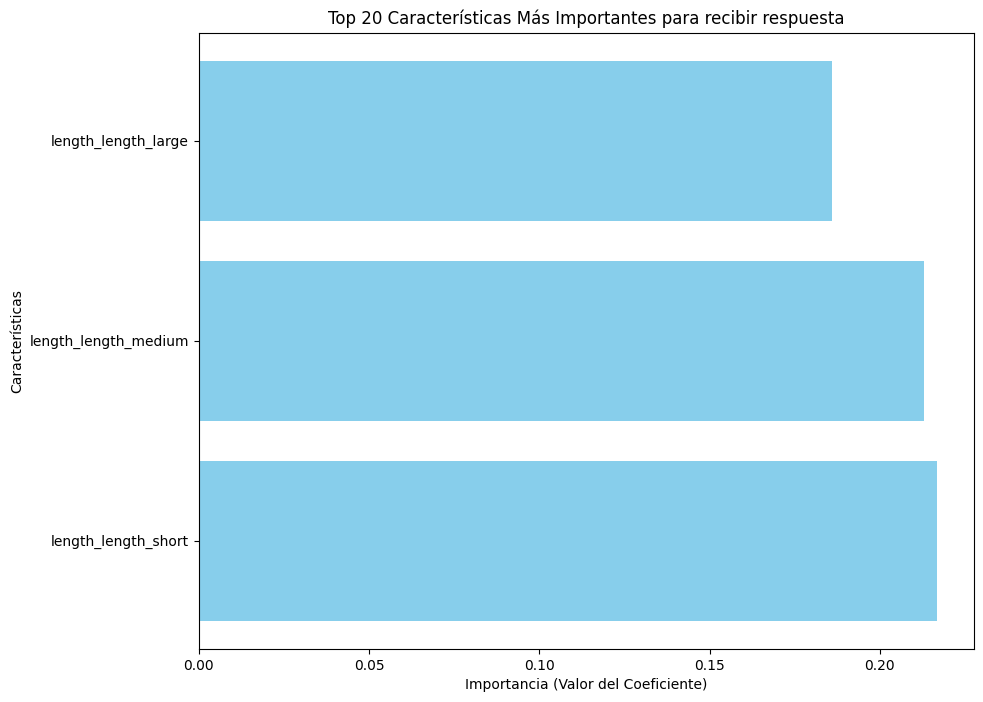

In [14]:
import matplotlib.pyplot as plt

# Asumiendo que sorted_features es tu DataFrame original
mask = ~sorted_features['Feature'].str.startswith('subject_') & ~sorted_features['Feature'].str.startswith('body_')& ~sorted_features['Feature'].str.startswith('num_')& ~sorted_features['Feature'].str.startswith('day_')& ~sorted_features['Feature'].str.startswith('remainder')& ~sorted_features['Feature'].str.startswith('time')

# Aplicar la máscara para filtrar el DataFrame
filtered_features = sorted_features[mask]

# Seleccionar las top 20 características por coeficiente absoluto
top_features = filtered_features.head(50)

# Crear un gráfico de barras
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Absolute_Coefficient'], color='skyblue')
plt.xlabel('Importancia (Valor del Coeficiente)')
plt.ylabel('Características')
plt.title('Top 20 Características Más Importantes para recibir respuesta')
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
plt.show()